<h1>Buffer Analysis and Optimization</h1>
Analysis of an Inverter Chain (Buffer) using a Jupyter notebook from which, via API calls to LTspice, it is possible to set the sizing factor of the inverters using the Monte Carlo method. Therefore, the Optimal Pareto Curve is analyzed through an optimization process and compared to the Monte Carlo experiments.

In [1]:
from properties import nr_runs, l_min_pmos, l_min_nmos, w_min_nmos, S1, S2, S_LOAD, tran, rit_models, save_s1, save_s2, w_min_pmos_step_param, save_w_min_pmos_analysis
from utils.conversion import to_order, Order
from utils.paths import ltspice, images, buffer_data, minimum_inverter_data, matlab
from utils.patterns import s1_pattern, s2_pattern, energy_connected_pattern, energy_disconnected_pattern, rise_delay_connected_pattern, fall_delay_connected_pattern, rise_delay_disconnected_pattern, fall_delay_disconnected_pattern, w_min_pmos_analysis_pattern
from utils.check import check_output_image
from optimization.optimize_function import optimize_considering_delay
from empirical.empiric_method import empiric_curve
from PyLTSpice import SimRunner
import re
import statistics as st
import matplotlib.pyplot as plt
import os
from models.ops import load_asc, load_ltr, energy_connected, energy_disconnected, rise_delay_connected, rise_delay_disconnected, fall_delay_connected, fall_delay_disconnected

<h2>Minimum Inverter Sizing Analysis</h2>
The dimensioning of a minimum inverter involves analysing it by considering an associated load, a Vin and a Vsupply. Specifically, what is analysed is the rise and fall time obtained at the output (Vout). It must be specified that the minimum PMOS sizing of the minimum inverter in question occurs at a rise time equal to the corresponding fall time or at least in an infinitesimal range thereof.

File opened successfully: ../../ltspice/models/minimum-inverter/get_sizing/minimum_inverter_sizing_analysis.asc


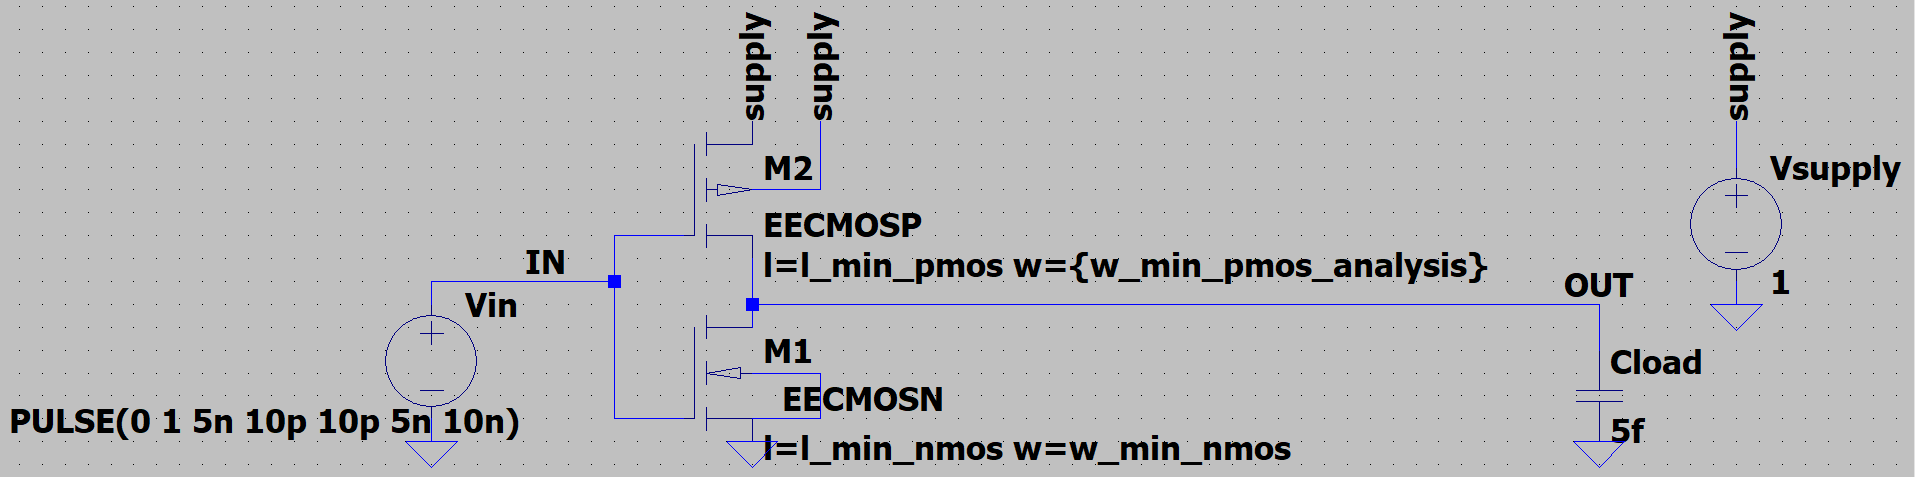

Fri Nov 24 23:18:41 2023 info: RunTask #1:: Starting simulation 1

Successful/Total Simulations: 0/1
Fri Nov 24 23:18:43 2023 info: RunTask #1:Simulation Successful. Time elapsed: 01.0889 secs

Fri Nov 24 23:18:43 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\get_sizing\minimum_inverter_sizing_analysis_1.raw, Log file: data\minimum-inverter\get_sizing\minimum_inverter_sizing_analysis_1.log
File opened successfully: data\minimum-inverter\get_sizing\minimum_inverter_sizing_analysis_1.raw
File updated successfully: ../../images/minimum_inverter_sizing_analysis_simulation.png


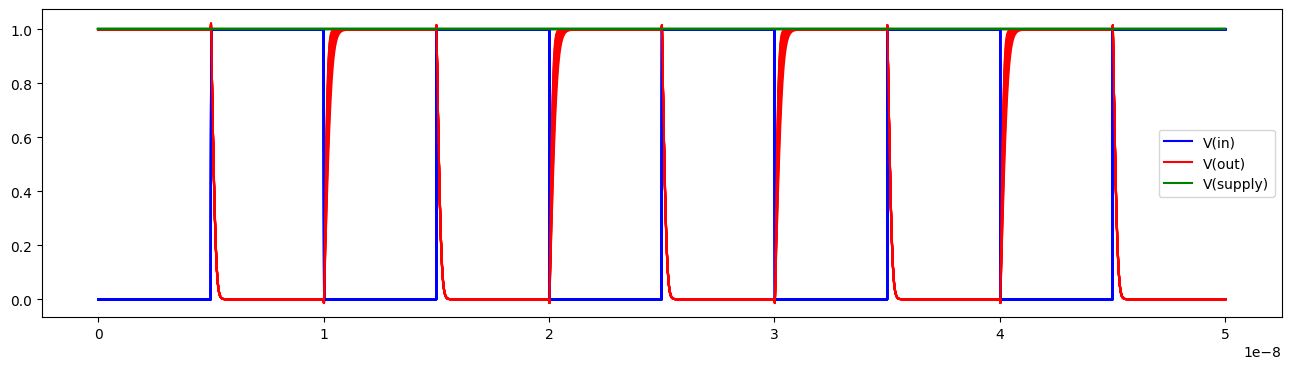

In [2]:
minimum_inverter_sizing_analysis_netlist = load_asc( 
                                                    asc_file_path=os.path.join(ltspice, "minimum-inverter/get_sizing/minimum_inverter_sizing_analysis.asc"), 
                                                    schematic_image_path=os.path.join(images, "minimum_inverter_sizing_analysis.png")
                                                    )
minimum_inverter_sizing_analysis_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_sizing_analysis_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_sizing_analysis_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_sizing_analysis_netlist.add_instructions(
                                rit_models,
                                tran,
                                w_min_pmos_step_param,
                                save_w_min_pmos_analysis,
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
minimum_inverter_sizing_analysis_runner = SimRunner(output_folder=f"{minimum_inverter_data}/get_sizing/")
minimum_inverter_sizing_analysis_runner.run(netlist=minimum_inverter_sizing_analysis_netlist, timeout=3600)
print('Successful/Total Simulations: ' + str(minimum_inverter_sizing_analysis_runner.okSim) + '/' + str(minimum_inverter_sizing_analysis_runner.runno))

minimum_inverter_sizing_analysis_raw = ""
minimum_inverter_sizing_analysis_log = ""
for minimum_inverter_sizing_analysis_raw, minimum_inverter_sizing_analysis_log in minimum_inverter_sizing_analysis_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_sizing_analysis_raw, minimum_inverter_sizing_analysis_log))
    

minimum_inverter_sizing_analysis_ltr = load_ltr(raw_file_path=minimum_inverter_sizing_analysis_raw)
v_in_minimum_inverter_sizing_analysis = minimum_inverter_sizing_analysis_ltr.get_trace("V(in)")
v_out_minimum_inverter_sizing_analysis = minimum_inverter_sizing_analysis_ltr.get_trace("V(out)")
v_supply_minimum_inverter_sizing_analysis = minimum_inverter_sizing_analysis_ltr.get_trace("V(supply)")
time = minimum_inverter_sizing_analysis_ltr.get_trace('time')
steps = minimum_inverter_sizing_analysis_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_minimum_inverter_sizing_analysis.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_minimum_inverter_sizing_analysis.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_minimum_inverter_sizing_analysis.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
minimum_inverter_sizing_analysis_simulation_path_image = os.path.join(images, "minimum_inverter_sizing_analysis_simulation.png")
check_output_image(minimum_inverter_sizing_analysis_simulation_path_image)
plt.savefig(minimum_inverter_sizing_analysis_simulation_path_image)
plt.show()

w_min_pmos_analysis = [1.2e-07, 1.3e-07, 1.4e-07, 1.5e-07, 1.6e-07, 1.7e-07, 1.8e-07, 1.9e-07, 2e-07, 2.1e-07, 2.2e-07, 2.3e-07, 2.4e-07]
File updated successfully: ../../images/w_min_pmos_analysis.png


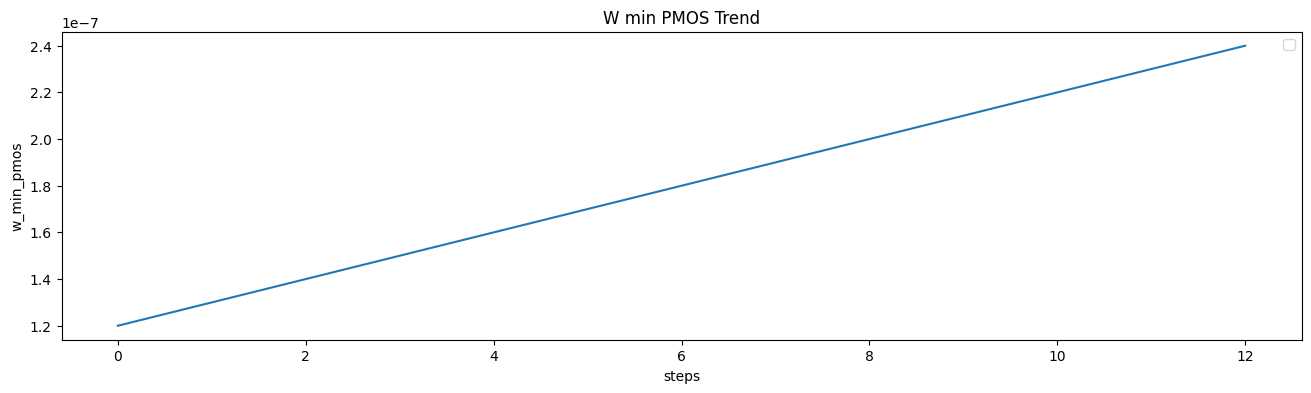

rise_delay-fall_delay = [6.6819e-11, 5.061500000000001e-11, 3.649699999999999e-11, 2.5663000000000018e-11, 1.6180999999999998e-11, 7.723999999999983e-12, 8.00000000000142e-14, 6.929999999999996e-12, 1.3409000000000013e-11, 1.847100000000001e-11, 2.2983000000000007e-11, 2.7123800000000002e-11, 3.0950800000000003e-11]
min(rise_delay-fall_delay) = 8.00000000000142e-14
w_min_pmos = 1.8e-07
w_min_pmos = 0.18u


In [3]:
minimum_inverter_sizing_analysis_log_file_path = f"./{minimum_inverter_sizing_analysis_log}"

with open(minimum_inverter_sizing_analysis_log_file_path, "r") as file:
    content = file.read()


w_min_pmos_analysis_data = re.search(w_min_pmos_analysis_pattern, content, re.DOTALL).group(1)
rise_delay_minimum_inverter_sizing_analysis_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_minimum_inverter_sizing_analysis_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

w_min_pmos_analysis_lines = w_min_pmos_analysis_data.strip().split('\n')[1:]
rise_delay_minimum_inverter_sizing_analysis_lines = rise_delay_minimum_inverter_sizing_analysis_data.strip().split('\n')[1:]
fall_delay_minimum_inverter_sizing_analysis_lines = fall_delay_minimum_inverter_sizing_analysis_data.strip().split('\n')[1:]


w_min_pmos_analysis = [float(line.split('\t')[1]) for line in w_min_pmos_analysis_lines]
print(f'w_min_pmos_analysis = {w_min_pmos_analysis}')
plt.figure(figsize=(16, 4))
plt.legend(['w_min_pmos_analysis'])
plt.plot(w_min_pmos_analysis, label='w_min_pmos_analysis')
plt.ylabel('w_min_pmos'); plt.xlabel('steps'); plt.title('W min PMOS Trend')
w_min_pmos_analysis_path_image = os.path.join(images, "w_min_pmos_analysis.png")
check_output_image(w_min_pmos_analysis_path_image)
plt.savefig(w_min_pmos_analysis_path_image)
plt.show()

rise_delay_minimum_inverter_sizing_analysis = [float(line.split('\t')[1]) for line in rise_delay_minimum_inverter_sizing_analysis_lines]

fall_delay_minimum_inverter_sizing_analysis = [float(line.split('\t')[1]) for line in fall_delay_minimum_inverter_sizing_analysis_lines]


diff_delay = [-1] * len(rise_delay_minimum_inverter_sizing_analysis) if len(rise_delay_minimum_inverter_sizing_analysis)==len(fall_delay_minimum_inverter_sizing_analysis) else -1
i = 0
for rise_delay, fall_delay in zip(rise_delay_minimum_inverter_sizing_analysis, fall_delay_minimum_inverter_sizing_analysis):
    diff_delay[i] = abs(rise_delay-fall_delay)
    i = i+1
print(f'rise_delay-fall_delay = {diff_delay}')

i_min_diff = 0
min_diff = diff_delay[i_min_diff]
for i in range(len(diff_delay)):
    if diff_delay[i] < min_diff:
        i_min_diff = i
        min_diff = diff_delay[i]
print(f'min(rise_delay-fall_delay) = {min_diff}')

w_min_pmos_value = 0
for i in range(len(w_min_pmos_analysis)):
    if i == i_min_diff:
        w_min_pmos_value = w_min_pmos_analysis[i]
print(f'w_min_pmos = {w_min_pmos_value}')
w_min_pmos = to_order(w_min_pmos_value, Order.MICRO)
w_min_pmos = str(w_min_pmos) + 'u'
print(f'w_min_pmos = {w_min_pmos}')

<blockquote>What has been done is to calculate the difference between the corresponding ascent time and descent time and consider the minimum of all calculated differences. What can be seen is that the differences are all almost very small (on the order of magnitude of 10e-11). One of them turns out to be even smaller than the others (of the order of magnitude 10e-14). Therefore, a corresponding width W of the PMOS transistor of 0.18u is obtained.</blockquote><hr>

<h2>Buffer Analysis</h2>
The buffer considered for the analysis of this project is a 3-stage chain inverter where the first inverter corresponds to the minimum sized inverter according to the previous analysis, the second inverter is sized S1 times the minimum inverter and the third inverter is sized S2 times the minimum inverter. Specifically, S1 and S2 are parameters defined according to Monte Carlo experiments. It must be specified that, to carry out the analysis, the buffer is connected to a load inverter sized 50 times the minimum inverter.

File opened successfully: ../../ltspice/models/buffer/standard/buffer.asc


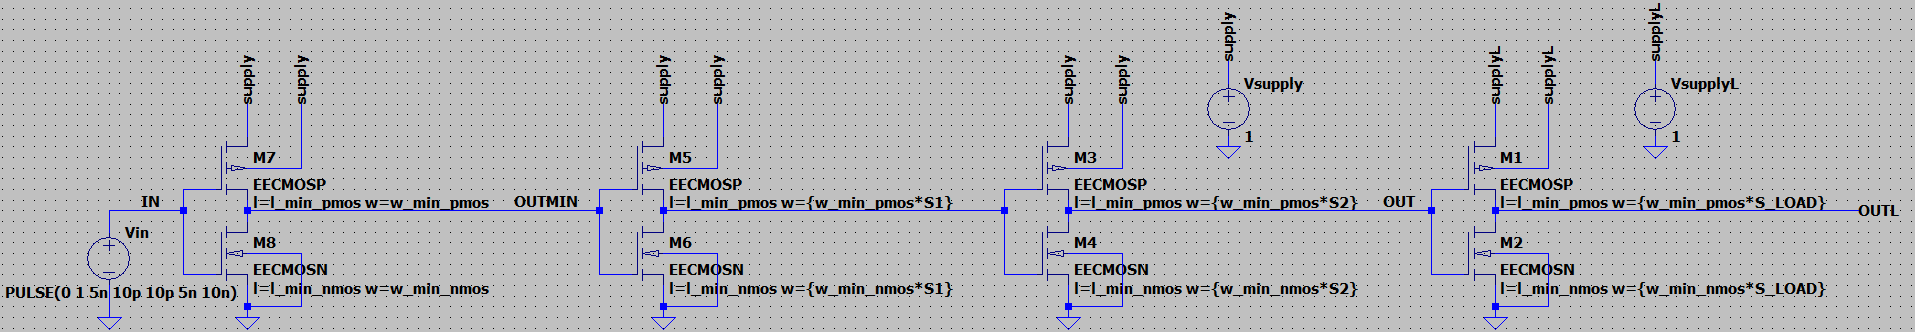

Fri Nov 24 23:18:46 2023 info: RunTask #1:: Starting simulation 1

Successful/Total Simulations: 0/1
Fri Nov 24 23:19:03 2023 info: RunTask #1:Simulation Successful. Time elapsed: 17.0337 secs

Fri Nov 24 23:19:03 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\standard\buffer_1.raw, Log file: data\buffer\standard\buffer_1.log
File opened successfully: data\buffer\standard\buffer_1.raw
File updated successfully: ../../images/buffer_simulation.png


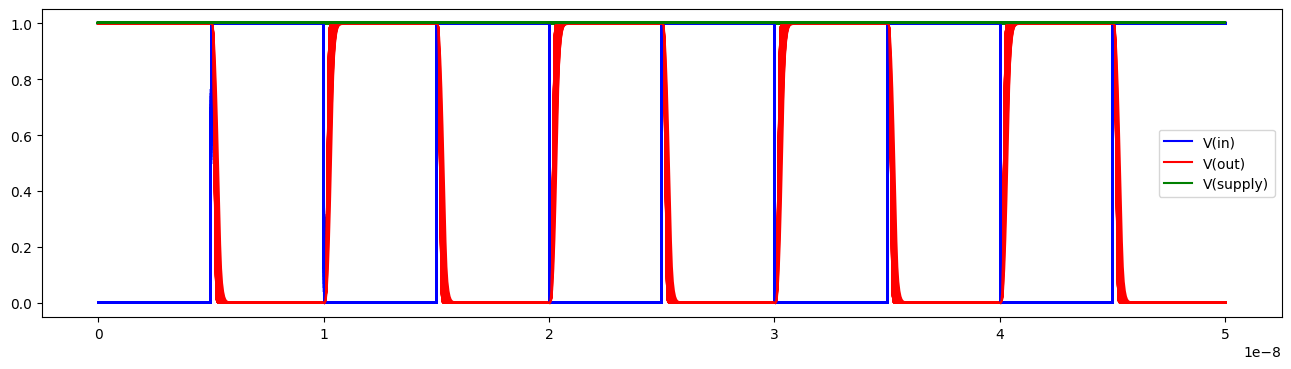

In [4]:
buffer_netlist = load_asc( 
                            asc_file_path=os.path.join(ltspice, "buffer/standard/buffer.asc"), 
                            schematic_image_path=os.path.join(images, "buffer.png")
                        )
buffer_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_netlist.set_parameter('S1', S1)
buffer_netlist.set_parameter('S2', S2)
buffer_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param run 1 {nr_runs} 1",
                                save_s1,
                                save_s2,
                                energy_connected(13, 22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_runner = SimRunner(output_folder=f"{buffer_data}/standard/")
buffer_runner.run(netlist=buffer_netlist, timeout=3600)
print('Successful/Total Simulations: ' + str(buffer_runner.okSim) + '/' + str(buffer_runner.runno))

buffer_raw = ""
buffer_log = ""
for buffer_raw, buffer_log in buffer_runner:
    print("Raw file: %s, Log file: %s" % (buffer_raw, buffer_log))
    

buffer_ltr = load_ltr(raw_file_path=buffer_raw)
v_in_buffer = buffer_ltr.get_trace("V(in)")
v_out_buffer = buffer_ltr.get_trace("V(out)")
v_supply_buffer = buffer_ltr.get_trace("V(supply)")
time = buffer_ltr.get_trace('time')
steps = buffer_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_simulation_path_image = os.path.join(images, "buffer_simulation.png")
check_output_image(buffer_simulation_path_image)
plt.savefig(buffer_simulation_path_image)
plt.show()

File updated successfully: ../../images/s1_s2_montecarlo_trend.png


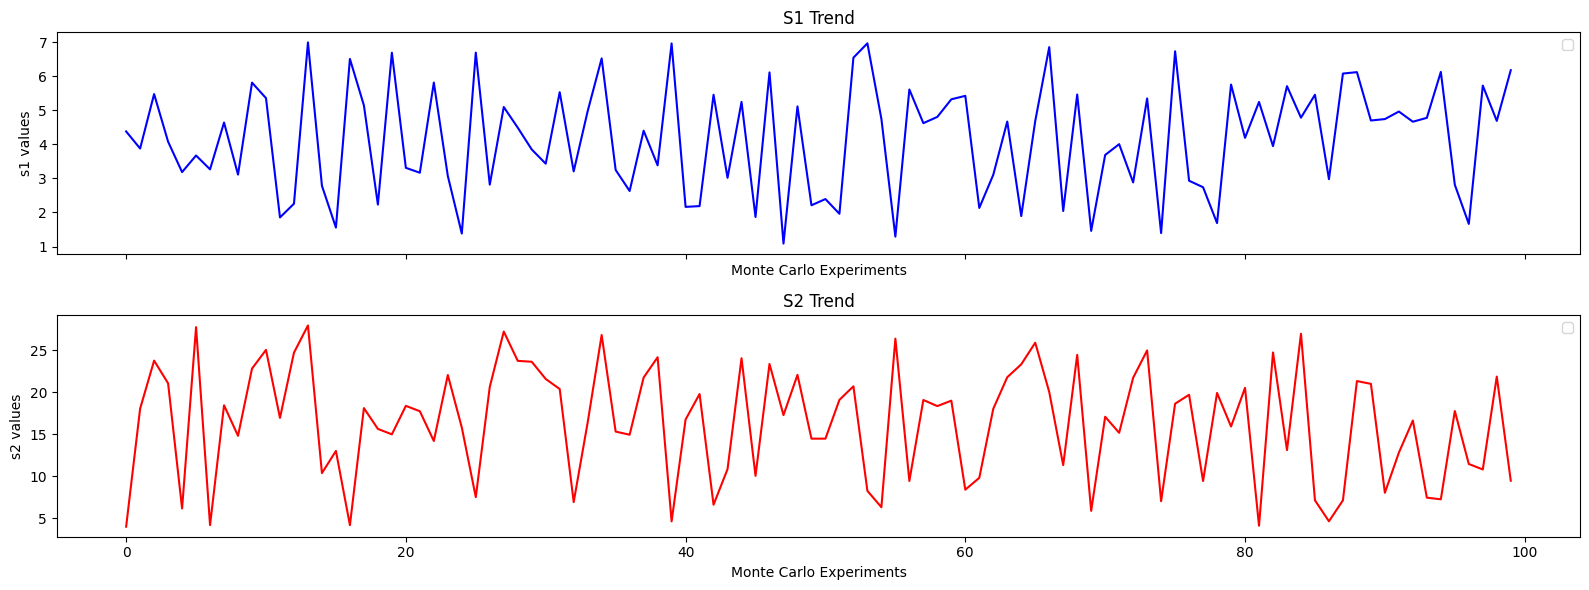

In [5]:
buffer_log_file_path = f"./{buffer_log}"

with open(buffer_log_file_path, "r") as file:
    content = file.read()

s1_data = re.search(s1_pattern, content, re.DOTALL).group(1)
s2_data = re.search(s2_pattern, content, re.DOTALL).group(1)
energy_connected_buffer_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

s1_lines = s1_data.strip().split('\n')[1:]
s2_lines = s2_data.strip().split('\n')[1:]
energy_connected_buffer_lines = energy_connected_buffer_data.strip().split('\n')[1:]
rise_delay_connected_buffer_lines = rise_delay_connected_buffer_data.strip().split('\n')[1:]
fall_delay_connected_buffer_lines = fall_delay_connected_buffer_data.strip().split('\n')[1:]


s1 = [float(line.split('\t')[1]) for line in s1_lines]
s2 = [float(line.split('\t')[1]) for line in s2_lines]


energy_connected_buffer = [float(line.split('\t')[1]) for line in energy_connected_buffer_lines]

energy_connected_buffer = [abs(energy) for energy in energy_connected_buffer]

rise_delay_connected_buffer = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_lines]

fall_delay_connected_buffer = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_lines]

delay_connected_buffer = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_connected_buffer,fall_delay_connected_buffer)]

    
fig, (plt1, plt2) = plt.subplots(2, 1, sharex=True, figsize=(16, 6))
plt1.legend(['S1']); plt2.legend(['S2'])
plt1.plot(s1, label='s1', color='b')
plt1.set_ylabel('s1 values'); plt1.set_xlabel('Monte Carlo Experiments'); plt1.set_title('S1 Trend')
plt2.plot(s2, label='s2', color='r')
plt2.set_xlabel('Monte Carlo Experiments'); plt2.set_ylabel('s2 values'); plt2.set_title('S2 Trend')
plt.tight_layout()
s1_s2_montecarlo_trend_path_image = os.path.join(images, "s1_s2_montecarlo_trend.png")
check_output_image(s1_s2_montecarlo_trend_path_image)
plt.savefig(s1_s2_montecarlo_trend_path_image)
plt.show()

<blockquote>It can be seen that the experiments conducted according to the Monte Carlo method actually reflect the design values: the values generated for S1 are around 4 with a variation of 0.75 and the values generated for S2 are around 16 with a variation of 0.75.</blockquote><hr>

<h2>Minimum Inverter Connected Analysis</h2>
The minimum connected inverter is used to calculate the energy, rise time and fall time to be connected. These parameters will be used later for further analysis. Considering the inverter connected means considering the output OUT to be connected to a load inverter.

File opened successfully: ../../ltspice/models/minimum-inverter/connected/minimum_inverter_connected.asc


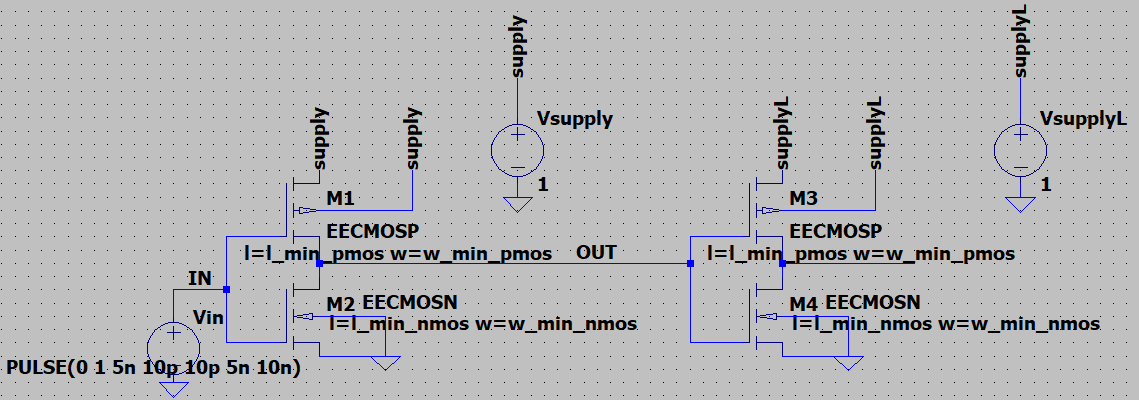

Fri Nov 24 23:19:13 2023 info: RunTask #1:: Starting simulation 1
Fri Nov 24 23:19:15 2023 info: RunTask #1:Simulation Successful. Time elapsed: 01.0741 secs

Fri Nov 24 23:19:15 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\connected\minimum_inverter_connected_1.raw, Log file: data\minimum-inverter\connected\minimum_inverter_connected_1.log


In [6]:
minimum_inverter_connected_netlist = load_asc(
                                                asc_file_path=os.path.join(ltspice, "minimum-inverter/connected/minimum_inverter_connected.asc"), 
                                                schematic_image_path=os.path.join(images, "minimum_inverter_connected.png")
                                            )
minimum_inverter_connected_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_connected_netlist.set_parameter('w_min_pmos', w_min_pmos)
minimum_inverter_connected_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_connected_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_connected_netlist.add_instructions(
                                rit_models,
                                tran,
                                ".step param run 1 2 1",
                                energy_connected(18, 22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
minimum_inverter_connected_runner = SimRunner(output_folder=f"{minimum_inverter_data}/connected/")
minimum_inverter_connected_runner.run(minimum_inverter_connected_netlist)

minimum_inverter_connected_raw = ""
minimum_inverter_connected_log = ""
for minimum_inverter_connected_raw, minimum_inverter_connected_log in minimum_inverter_connected_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_connected_raw, minimum_inverter_connected_log))

In [7]:
minimum_inverter_connected_log_file_path = f"./{minimum_inverter_connected_log}"

with open(minimum_inverter_connected_log_file_path, "r") as file:
    content = file.read()

energy_connected_minimum_inverter_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_minimum_inverter_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_minimum_inverter_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_minimum_inverter_lines = energy_connected_minimum_inverter_data.strip().split('\n')[1:]
rise_delay_connected_minimum_inverter_lines = rise_delay_connected_minimum_inverter_data.strip().split('\n')[1:]
fall_delay_connected_minimum_inverter_lines = fall_delay_connected_minimum_inverter_data.strip().split('\n')[1:]


energy_connected_minimum_inverter = [float(line.split('\t')[1]) for line in energy_connected_minimum_inverter_lines]

energy_connected_minimum_inverter = [abs(energy) for energy in energy_connected_minimum_inverter]

rise_delay_connected_minimum_inverter = [float(line.split('\t')[1]) for line in rise_delay_connected_minimum_inverter_lines]

fall_delay_connected_minimum_inverter = [float(line.split('\t')[1]) for line in fall_delay_connected_minimum_inverter_lines]

<h2>Minimum Inverter Disconnected Analysis</h2>
The minimum disconnected inverter is used to calculate the energy, rise time and fall time from disconnected. These parameters will be used later for further analysis. Considering the inverter disconnected means considering the output OUT from the load inverter to be disconnected.

File opened successfully: ../../ltspice/models/minimum-inverter/disconnected/minimum_inverter_disconnected.asc


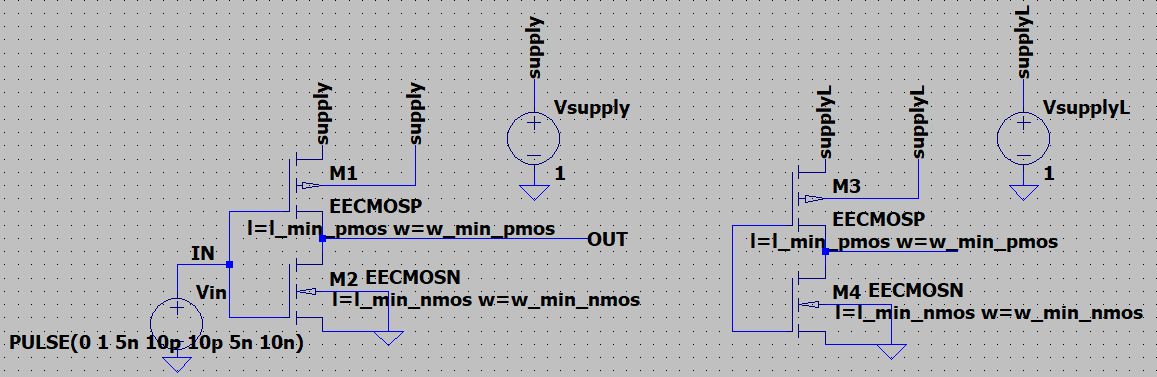

Fri Nov 24 23:19:17 2023 info: RunTask #1:: Starting simulation 1
Fri Nov 24 23:19:23 2023 info: RunTask #1:Simulation Successful. Time elapsed: 06.0266 secs

Fri Nov 24 23:19:23 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\minimum-inverter\disconnected\minimum_inverter_disconnected_1.raw, Log file: data\minimum-inverter\disconnected\minimum_inverter_disconnected_1.log


In [8]:
minimum_inverter_disconnected_netlist = load_asc(
                                                 asc_file_path=os.path.join(ltspice, "minimum-inverter/disconnected/minimum_inverter_disconnected.asc"), 
                                                 schematic_image_path=os.path.join(images, "minimum_inverter_disconnected.png")
                                                )
minimum_inverter_disconnected_netlist.set_parameter('l_min_pmos', l_min_pmos)
minimum_inverter_disconnected_netlist.set_parameter('w_min_pmos', w_min_pmos)
minimum_inverter_disconnected_netlist.set_parameter('l_min_nmos', l_min_nmos)
minimum_inverter_disconnected_netlist.set_parameter('w_min_nmos', w_min_nmos)
minimum_inverter_disconnected_netlist.add_instructions(
                                rit_models,
                                tran,
                                ".step param run 1 2 1",
                                energy_disconnected(18, 22),
                                rise_delay_disconnected(),
                                fall_delay_disconnected()
                        )
minimum_inverter_disconnected_runner = SimRunner(output_folder=f"{minimum_inverter_data}/disconnected/")
minimum_inverter_disconnected_runner.run(minimum_inverter_disconnected_netlist)

minimum_inverter_disconnected_raw = ""
minimum_inverter_disconnected_log = ""
for minimum_inverter_disconnected_raw, minimum_inverter_disconnected_log in minimum_inverter_disconnected_runner:
    print("Raw file: %s, Log file: %s" % (minimum_inverter_disconnected_raw, minimum_inverter_disconnected_log))

In [9]:
minimum_inverter_disconnected_log_file_path = f"./{minimum_inverter_disconnected_log}"

with open(minimum_inverter_disconnected_log_file_path, "r") as file:
    content = file.read()

energy_disconnected_minimum_inverter_data = re.search(energy_disconnected_pattern, content, re.DOTALL).group(1)
rise_delay_disconnected_minimum_inverter_data = re.search(rise_delay_disconnected_pattern, content, re.DOTALL).group(1)
fall_delay_disconnected_minimum_inverter_data = re.search(fall_delay_disconnected_pattern, content, re.DOTALL).group(1)

energy_disconnected_minimum_inverter_lines = energy_disconnected_minimum_inverter_data.strip().split('\n')[1:]
rise_delay_disconnected_minimum_inverter_lines = rise_delay_disconnected_minimum_inverter_data.strip().split('\n')[1:]
fall_delay_disconnected_minimum_inverter_lines = fall_delay_disconnected_minimum_inverter_data.strip().split('\n')[1:]


energy_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in energy_disconnected_minimum_inverter_lines]

energy_disconnected_minimum_inverter = [abs(energy) for energy in energy_disconnected_minimum_inverter]

rise_delay_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in rise_delay_disconnected_minimum_inverter_lines]

fall_delay_disconnected_minimum_inverter = [float(line.split('\t')[1]) for line in fall_delay_disconnected_minimum_inverter_lines]

delay_disconnected_minimum_inverter = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_disconnected_minimum_inverter,fall_delay_disconnected_minimum_inverter)]

<h2>Overall Buffer Analysis via Monte Carlo Experiments</h2>
At this point, the energy-delay points obtained after considering the random variables S1 and S2 by means of the Monte Carlo method and after simulating the 3-stage buffer are plotted. Specifically, the plot considered is of the scatter type with the delay on the abscissas and the energy on the ordinates. Performing an initial empirical analysis, it is possible to note that the optimum possible points from the point of view of low power could be represented by all the points that present an energy-delay trade-off that makes their ratio as low as possible, or at the same energy considering even greater delays. This last statement allows us to consider a buffer with low power criteria, which is our goal while considering longer delays. Therefore, the optimal possible curve could coincide with the minimum points obtained from the simulations considering Monte Carlo experiments and visible in the scatter plot. It must be specified that this curve is not necessarily the optimal one. In fact, this has to be confirmed by means of unconstrained optimisation with 2 variables, S1 and S2, using the scipy.minimise optimisation algorithm available in Python or fmincon in MATLAB. Therefore, the optimal curve will then be generated and compared with the scatter plot energy-delay obtained.

File updated successfully: ../../images/montecarlo_experiments.png


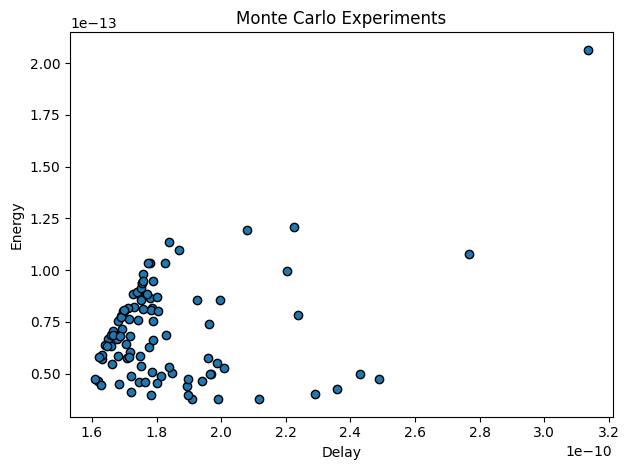

In [10]:
plt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
plt.xlabel('Delay'); plt.ylabel('Energy'); plt.title('Monte Carlo Experiments')
plt.tight_layout()
scatter_montecarlo_experiments_path_image = os.path.join(images, "montecarlo_experiments.png")
check_output_image(scatter_montecarlo_experiments_path_image)
plt.savefig(scatter_montecarlo_experiments_path_image)
plt.show()

In [11]:
'''
offset_empirical = 0.0003
delay_fit, energy_fit = empiric_curve(delay_connected_buffer, energy_connected_buffer, offset_empirical, 100)

plt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
plt.plot(delay_fit, energy_fit, color='red')
plt.show()
'''

"\noffset_empirical = 0.0003\ndelay_fit, energy_fit = empiric_curve(delay_connected_buffer, energy_connected_buffer, offset_empirical, 100)\n\nplt.scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')\nplt.plot(delay_fit, energy_fit, color='red')\nplt.show()\n"

In [12]:
vdd = 1

c_tot = [energy / (vdd*vdd) for energy in energy_connected_minimum_inverter]

c_out = [energy / (vdd*vdd) for energy in energy_disconnected_minimum_inverter]

c_in = [c_tot - c_out for c_tot, c_out in zip(c_tot, c_out)]

c_min = c_in[0]

print(f"c_min = {c_min}")
c_min_for_optimization = to_order(c_min, Order.FEMTO)
print(f"c_min_for_optimization = {c_min_for_optimization}")

gamma_e = [c_out / c_in for c_out, c_in in zip(c_out, c_in)]
print(f"gamma_e_max = {max(gamma_e)}")
print(f"gamma_e_min = {min(gamma_e)}")
gamma_e = st.mean(gamma_e)
print(f"gamma_e = {gamma_e}")

c_min = 7.58786e-16
c_min_for_optimization = 0.758786
gamma_e_max = 0.6290232028529783
gamma_e_min = 0.6290232028529783
gamma_e = 0.6290232028529783


<blockquote>Considering that E = C * Vdd^2 then it is possible to derive the capacity with the inverse formula: C = E / Vdd^2. Therefore, the total capacity c_tot will be obtained by considering the energy associated with the minimum connected inverter, the output capacity c_out will be obtained by considering the energy associated with the minimum disconnected inverter, and finally, the input capacity c_in is obtained via the difference between the total capacity c_tot and the output capacity c_out. Therefore, the gamma_e parameter can be calculated via the ratio of the intrinsic output capacitance c_out to the input capacitance c_in.</blockquote>

In [13]:
tau_nom = delay_disconnected_minimum_inverter
tau_nom = st.mean(tau_nom)
print(f"tau_nom = {tau_nom}")
tau_nom_for_optimization = to_order(tau_nom, Order.PICO)
print(f"tau_nom_for_optimization = {tau_nom_for_optimization}")

tau_tot = delay_connected_buffer

s_load = 50

temp1 = [tau_nom / (tau_tot-(3*tau_nom)) for tau_tot in tau_tot]
temp2 = [s1 + (s2/s1) + (s_load/s2) for s1, s2 in zip(s1, s2)]
gamma_d =  [tmp1 * tmp2 for tmp1, tmp2 in zip(temp1, temp2)]
print(f"gamma_d_max = {max(gamma_d)}")
print(f"gamma_d_min = {min(gamma_d)}")
gamma_d = st.mean( gamma_d )
print(f"gamma_d = {gamma_d}")

tau_nom = 7.856585e-12
tau_nom_for_optimization = 7.856585
gamma_d_max = 0.6858153802588443
gamma_d_min = 0.6149452034632888
gamma_d = 0.6348878893802855


<blockquote>The parameter tau_nom is equal to the delay associated with the minimum disconnected inverter. Specifically, the latter is obtained by averaging the rise time and the fall time of the inverter itself. The tau_tot, on the other hand, is equal to the delay associated with the connected buffer where the latter is calculated as the average between the rise time and the fall time of the buffer itself. Therefore, considering a load inverter sizing factor of 50, through the delay model associated with the 3-stage buffer, the associated gamma_d can be calculated.</blockquote>

<h1>Optmization</h1>


File updated successfully: ../../images/s1_s2_optimized.png


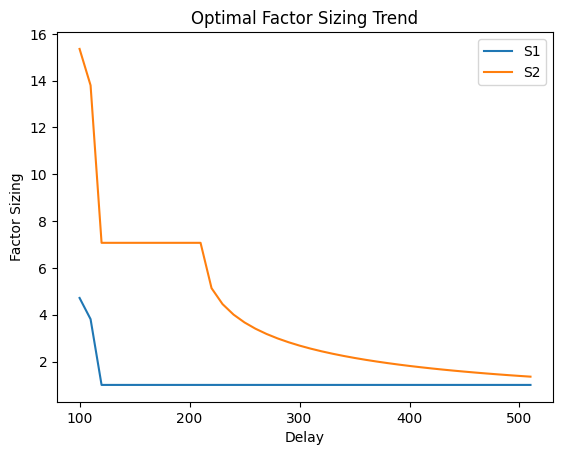

delay      optimal_point                  objective_f_value                   iterations     
510        [1.         1.35298696]        41.32507411834068                   14             
500        [1.         1.38443857]        41.36395082600292                   13             
490        [1.        1.4174499]          41.404755476796076                  15             
480        [1.         1.45214498]        41.44764137040269                   12             
470        [1.         1.48866189]        41.492779188008164                  12             
460        [1.         1.52715492]        41.54035965244022                   12             
450        [1.         1.56779709]        41.59059663235781                   12             
440        [1.         1.61078326]        41.6437309677678                    12             
430        [1.         1.65633377]        41.70003505215                      14             
420        [1.         1.70469904]        41.75981838619199 

In [14]:
optimal_results = []

c_min = c_min_for_optimization
tau_nom = tau_nom_for_optimization
s0 = [10, 10]
max_iter = 10000

s1_from_python = []
s2_from_python = []
delay_values = []

d_max = 510
d_min = 100
step_opt = 10

for delay in range(d_max, d_min - 1, -step_opt):
    variables, energy_value, iteration_count = optimize_considering_delay(delay, tau_nom, gamma_d, s_load, vdd, c_min, gamma_e, s0, max_iter)
    optimal_results.append((delay, variables, energy_value, iteration_count))
    s1_from_python.append(variables[0])
    s2_from_python.append(variables[1])
    delay_values.append(delay)

plt.plot(delay_values, s1_from_python, label='S1')
plt.plot(delay_values, s2_from_python, label='S2')
plt.legend()
plt.xlabel('Delay'); plt.ylabel('Factor Sizing'); plt.title('Optimal Factor Sizing Trend')
s1_s2_optimized_path_image = os.path.join(images, "s1_s2_optimized.png")
check_output_image(s1_s2_optimized_path_image)
plt.savefig(s1_s2_optimized_path_image)
plt.show()

print("{:<10} {:<30} {:<35} {:<15}".format("delay", "optimal_point", "objective_f_value", "iterations"))
for delay, variables, energy_value, iteration_count in optimal_results:
    print("{:<10} {:<30} {:<35} {:<15}".format(delay, str(variables), energy_value, iteration_count))

<blockquote>Optimization unconstrained by 2 variables, S1 and S2, can be performed using the scipy.minimise optimization algorithm. Specifically, the SLSQP algorithm was chosen, which performs a non-linear optimization and, in addition, 2 constraints on the delay were considered: one of equality and one of inequality. The parameters used, scaled appropriately, are those previously calculated. It must be specified that an initial point S0 was chosen for the optimization, assuming, therefore, that the initial scaling factors S1 and S2 are both equal to 10. Furthermore, it has been specified that the maximum number of iterations of the algorithm, for each optimization performed, is equal to 10000. Therefore, considering a delay range [d_max,d_min] = [510,100] to obtain a better optimization scaling of the sizing, we will obtain d_max-d_min/step, where step=10 is the optimization step between one delay considered and the next, optimum sizing factors considering the design parameters calculated previously.</blockquote><hr>

<h2>Comparative Analysis</h2>


File opened successfully: ../../ltspice/models/buffer/optimized/buffer_optimized.asc


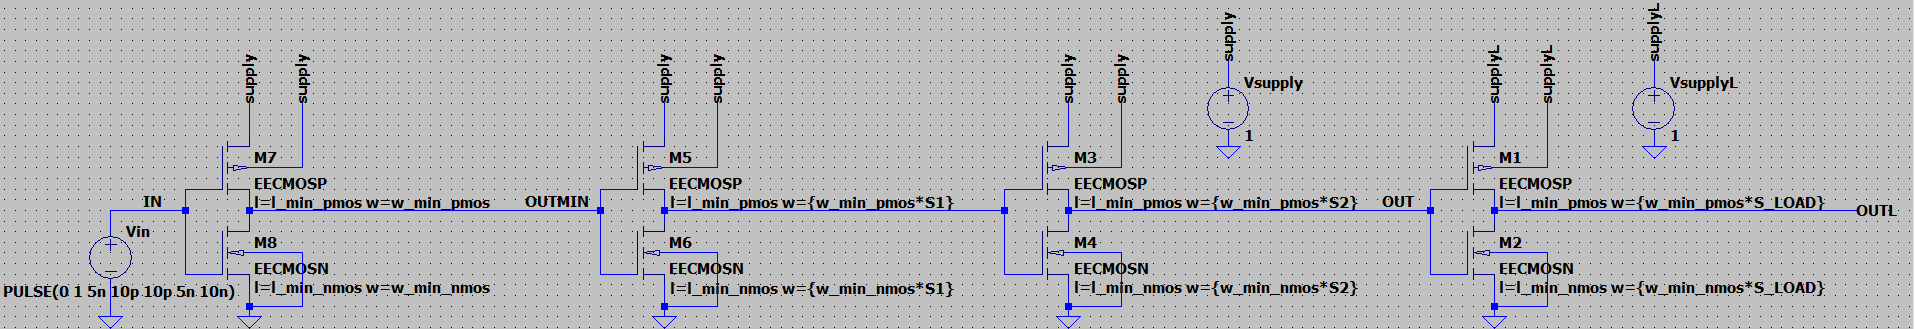

Fri Nov 24 23:19:31 2023 info: RunTask #1:: Starting simulation 1
Fri Nov 24 23:19:42 2023 info: RunTask #1:Simulation Successful. Time elapsed: 10.0229 secs

Fri Nov 24 23:19:42 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\optimized\buffer_optimized_1.raw, Log file: data\buffer\optimized\buffer_optimized_1.log
File opened successfully: data\buffer\optimized\buffer_optimized_1.raw
File updated successfully: ../../images/buffer_optimized_simulation.png


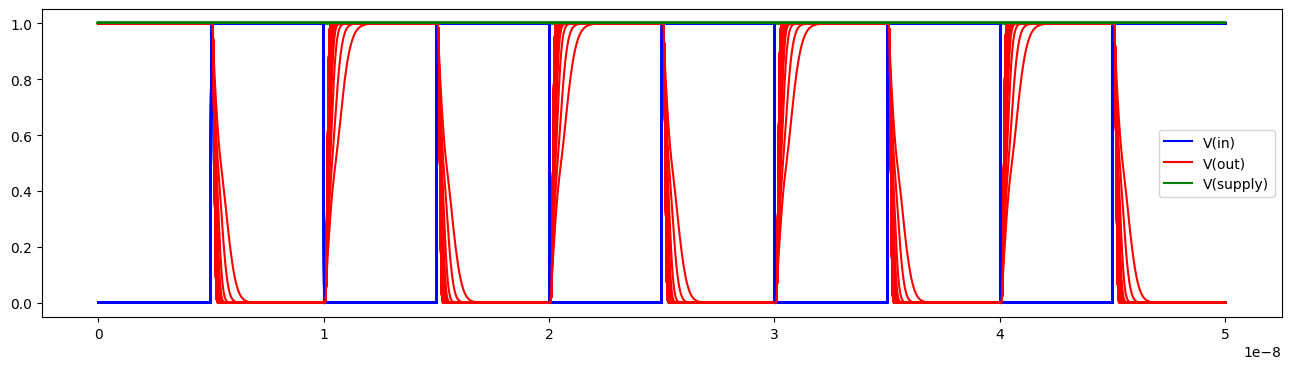

In [15]:
buffer_optimized_netlist = load_asc(
                                    asc_file_path=os.path.join(ltspice, "buffer/optimized/buffer_optimized.asc"), 
                                    schematic_image_path=os.path.join(images, "buffer_optimized.png")
                                )
n_runs_optimized = ((d_max - d_min)/step_opt) + 1

tmp_s1 = [(str(var1)+"," if var1 != s1_from_python[len(s1_from_python) - 1] else str(var1)) for var1 in s1_from_python]
s1_table_optimized = ""
for item in tmp_s1:
    s1_table_optimized = s1_table_optimized + item
tmp_s2 = [(str(var2)+"," if var2 != s2_from_python[len(s2_from_python) - 1] else str(var2)) for var2 in s2_from_python]
s2_table_optimized = ""
for item in tmp_s2:
    s2_table_optimized = s2_table_optimized + item

S1_optimized = f' table(index,{s1_table_optimized})'
S2_optimized = f' table(index,{s2_table_optimized})'

buffer_optimized_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_optimized_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_optimized_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_optimized_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_optimized_netlist.set_parameter('S1', S1_optimized)
buffer_optimized_netlist.set_parameter('S2', S2_optimized)
buffer_optimized_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_optimized_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param index 1 {n_runs_optimized} 1",
                                energy_connected(13,22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_optimized_runner = SimRunner(output_folder=f"{buffer_data}/optimized/")
buffer_optimized_runner.run(buffer_optimized_netlist)

buffer_optimized_raw = ""
buffer_optimized_log = ""
for buffer_optimized_raw, buffer_optimized_log in buffer_optimized_runner:
    print("Raw file: %s, Log file: %s" % (buffer_optimized_raw, buffer_optimized_log))


buffer_optimized_ltr = load_ltr(raw_file_path=buffer_optimized_raw)
v_in_buffer_optimized = buffer_optimized_ltr.get_trace("V(in)")
v_out_buffer_optimized = buffer_optimized_ltr.get_trace("V(out)")
v_supply_buffer_optimized = buffer_optimized_ltr.get_trace("V(supply)")
time = buffer_optimized_ltr.get_trace('time')
steps = buffer_optimized_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer_optimized.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer_optimized.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer_optimized.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_optimized_simulation_path_image = os.path.join(images, "buffer_optimized_simulation.png")
check_output_image(buffer_optimized_simulation_path_image)
plt.savefig(buffer_optimized_simulation_path_image)
plt.show()

In [16]:
buffer_optimized_log_file_path = f"./{buffer_optimized_log}"

with open(buffer_optimized_log_file_path, "r") as file:
    content = file.read()

energy_connected_buffer_optimized_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_optimized_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_optimized_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_buffer_optimized_lines = energy_connected_buffer_optimized_data.strip().split('\n')[1:]
rise_delay_connected_buffer_optimized_lines = rise_delay_connected_buffer_optimized_data.strip().split('\n')[1:]
fall_delay_connected_buffer_optimized_lines = fall_delay_connected_buffer_optimized_data.strip().split('\n')[1:]


energy_connected_buffer_optimized = [float(line.split('\t')[1]) for line in energy_connected_buffer_optimized_lines]
energy_connected_buffer_optimized = [abs(energy) for energy in energy_connected_buffer_optimized]

rise_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_optimized_lines]

fall_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_optimized_lines]

delay_connected_buffer_optimized = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_connected_buffer_optimized,fall_delay_connected_buffer_optimized)]

A comparative graphical analysis is carried out between the newly obtained optimal curve, via an optimisation algorithm, and the empirical analysis, previously obtained via Monte Carlo experiments.

File updated successfully: ../../images/comparative_analysis.png


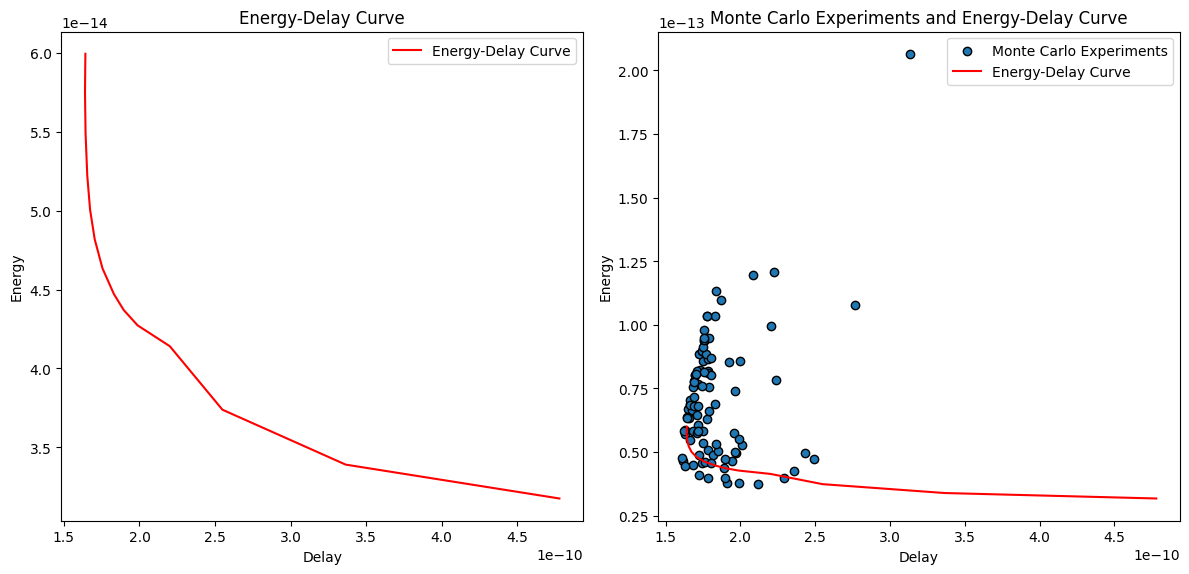

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[0].set_xlabel('Delay')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy-Delay Curve')
axs[0].legend(["Energy-Delay Curve"])

axs[1].scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
axs[1].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[1].set_xlabel('Delay')
axs[1].set_ylabel('Energy')
axs[1].set_title('Monte Carlo Experiments and Energy-Delay Curve')
axs[1].legend(["Monte Carlo Experiments", "Energy-Delay Curve"])

plt.tight_layout()

comparative_analysis_path_image = os.path.join(images, "comparative_analysis.png")
check_output_image(comparative_analysis_path_image)
plt.savefig(comparative_analysis_path_image)
plt.show()

delay_connected_buffer_optimized_python = delay_connected_buffer_optimized
energy_connected_buffer_optimized_python = energy_connected_buffer_optimized

<blockquote>It is possible to observe how the optimal curve obtained by means of the optimisation algorithm slightly approximates the minimum points obtained by means of Monte Carlo experiments, i.e. the possible empirical curve hypothesised to contour the minimum points of the scatter plot according to the reasoning previously made. It must be specified that this possible optimal Pareto curve obtained by means of the optimisation algorithm depends on the implementation of the algorithm itself and, therefore, with different algorithms one could obtain a better approximation of the hypothesised empirical curve or even a worse one.</blockquote><hr>

<h1>To MATLAB</h1>

In [18]:
data_to_matlab_file_path = os.path.join(matlab, "buffer_data.txt")

with open(data_to_matlab_file_path, "w") as file:
    file.truncate(0)
    file.write(f"{vdd}\n")
    file.write(f"{c_min}\n")
    file.write(f"{gamma_e}\n")
    file.write(f"{tau_nom}\n")
    file.write(f"{gamma_d}\n")
    file.write(f"{S_LOAD}\n")
    file.write(f"{s0[0]}\n")
    file.write(f"{s0[1]}\n")
    file.write(f"{d_max}\n")
    file.write(f"{d_min}\n")

print(f"Variables written successfully: {data_to_matlab_file_path}")

Variables written successfully: ../../matlab/buffer_data.txt


<h1>From MATLAB</h1>
<strong>At this point you need to open MATLAB and run the '../../matlab/optimization' script so as to generate the optimized values of the sizing factors S1 and S2 and make a comparison between those generated by the 'fmincon' optimization algorithm present in MATLAB and those generated by the algorithm scipy.minimize optimization tool of type 'SLSQP'. Therefore, you will be asked if you can continue with the execution. This will only be possible by entering the word 'continue' in the popup window which will indicate that the MATLAB script has been executed and you can continue with the execution of the Jupyter notebook. Obviously this popup window is indicative. So much so that in the case of invalid input, execution continues as the exception is caught and handled. It is just to remind the user that before executing the next code it is necessary to execute the MATLAB script '../../matlab/optimization' because otherwise there would be a risk of generating errors or inconsistent results.</strong>

In [19]:
try:
    user_input = input("Write 'continue' if and only if the MATLAB script has been launched: ")
    if user_input.lower() == 'continue':
        print("You entered 'continue'. The execution continues.")
    else:
        raise ValueError("Input other than 'continue'. Execution stopped.")
except ValueError as e:
    print("Error:", e)


You entered 'continue'. The execution continues.


File updated successfully: ../../images/s1_s2_matlab_optimized.png


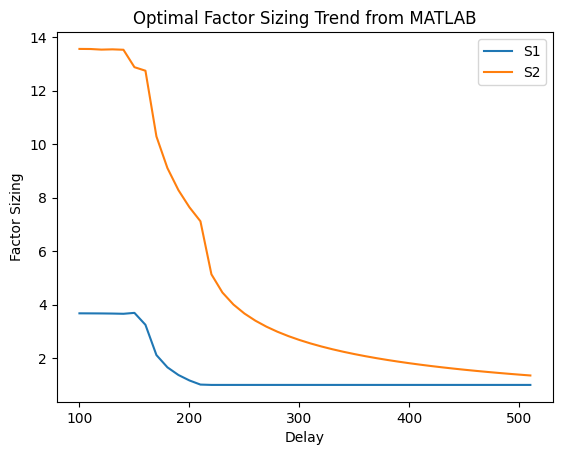

delay      s1_from_matlab                      s2_from_matlab                     
510        1.0                                 1.352987                           
500        1.0                                 1.384439                           
490        1.0                                 1.41745                            
480        1.0                                 1.452145                           
470        1.0                                 1.488662                           
460        1.0                                 1.527155                           
450        1.0                                 1.567797                           
440        1.0                                 1.610783                           
430        1.0                                 1.656334                           
420        1.0                                 1.704699                           
410        1.0                                 1.756165                           
400 

In [20]:
data_from_matlab_directory = f"{matlab}/data"
s1_data_from_matlab_file = "s1_data.txt"
s2_data_from_matlab_file = "s2_data.txt"
s1_data_from_matlab_file_path = os.path.join(data_from_matlab_directory, s1_data_from_matlab_file)
s2_data_from_matlab_file_path = os.path.join(data_from_matlab_directory, s2_data_from_matlab_file)
with open(s1_data_from_matlab_file_path, 'r') as s1_file:
    s1_lines = s1_file.readlines()
with open(s2_data_from_matlab_file_path, 'r') as s2_file:
    s2_lines = s2_file.readlines()

s1_from_matlab = []
s2_from_matlab = []

for line in s1_lines:
    columns = line.split()
    if columns:
        s1_value = columns[0]
        s1_from_matlab.append(float(s1_value))
for line in s2_lines:
    columns = line.split()
    if columns:
        s2_value = columns[0]
        s2_from_matlab.append(float(s2_value))


plt.plot(delay_values, s1_from_matlab, label='S1')
plt.plot(delay_values, s2_from_matlab, label='S2')
plt.legend()
plt.xlabel('Delay'); plt.ylabel('Factor Sizing'); plt.title('Optimal Factor Sizing Trend from MATLAB')
s1_s2_optimized_from_matlab_path_image = os.path.join(images, "s1_s2_matlab_optimized.png")
check_output_image(s1_s2_optimized_from_matlab_path_image)
plt.savefig(s1_s2_optimized_from_matlab_path_image)
plt.show()

print("{:<10} {:<35} {:<35}".format("delay", "s1_from_matlab", "s2_from_matlab"))
for delay, s1_matlab, s2_matlab in zip(delay_values, s1_from_matlab, s2_from_matlab):
    print("{:<10} {:<35} {:<35}".format(delay, str(s1_matlab), str(s2_matlab)))

<blockquote>It can be seen that the optimal dimensioning factors generated by MATLAB follow a trend in the delay range almost very similar to that generated by the scipy.minimise optimisation algorithm.</blockquote><hr>

In [21]:
print("{:<10} {:<25} {:<25} {:<25} {:<25}".format("delay", "s1_from_python", "s1_from_matlab", "s2_from_python", "s2_from_matlab"))
for delay, s1_python, s2_python, s1_matlab, s2_matlab in zip(delay_values, s1_from_python, s2_from_python, s1_from_matlab, s2_from_matlab):
    print("{:<10} {:<25} {:<25} {:<25} {:<25}".format(delay, str(s1_python), str(s1_matlab), str(s2_python), str(s2_matlab)))

delay      s1_from_python            s1_from_matlab            s2_from_python            s2_from_matlab           
510        1.0                       1.0                       1.3529869574304894        1.352987                 
500        1.0                       1.0                       1.3844385687034202        1.384439                 
490        1.0                       1.0                       1.4174499035629438        1.41745                  
480        1.0                       1.0                       1.4521449828511834        1.452145                 
470        1.0                       1.0                       1.4886618892047194        1.488662                 
460        1.0                       1.0                       1.5271549191316307        1.527155                 
450        1.0                       1.0                       1.567797094328693         1.567797                 
440        1.0                       1.0                       1.610783256559283

In [22]:
s1_error = []
s2_error = []
print("{:<10} {:<25} {:<25}".format("delay", "s1_error", "s2_error"))
for delay, s1_python, s2_python, s1_matlab, s2_matlab in zip(delay_values, s1_from_python, s2_from_python, s1_from_matlab, s2_from_matlab):
    s1_error_current = abs(s1_python - s1_matlab)
    s2_error_current = abs(s2_python - s2_matlab)
    s1_error.append(s1_error_current)
    s2_error.append(s2_error_current)
    print("{:<10} {:<25} {:<25}".format(delay, str(s1_error_current), str(s2_error_current)))

delay      s1_error                  s2_error                 
510        0.0                       4.256951058323466e-08    
500        0.0                       4.3129657978369096e-07   
490        0.0                       9.643705634054811e-08    
480        0.0                       1.7148816588985483e-08   
470        0.0                       1.1079528050572662e-07   
460        0.0                       8.086836933429709e-08    
450        0.0                       9.432869285674883e-08    
440        0.0                       2.56559283595692e-07     
430        0.0                       2.2536567034769917e-07   
420        0.0                       3.743446574944187e-08    
410        0.0                       4.7373300171571486e-08   
400        0.0                       3.148768097371857e-07    
390        0.0                       4.996877245311282e-07    
380        0.0                       3.9385509631451043e-07   
370        0.0                       3.1043118742246634

File updated successfully: ../../images/s_optimized_error.png


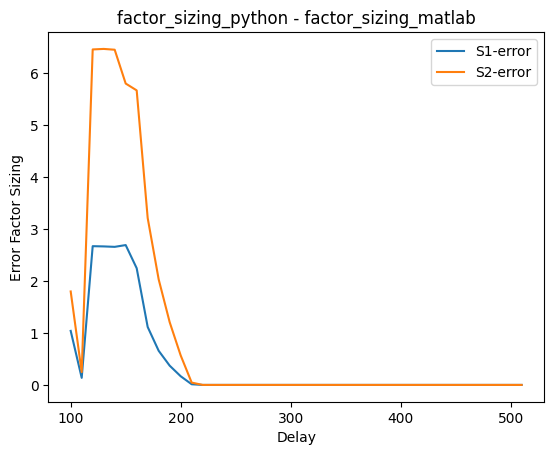

In [23]:
plt.plot(delay_values, s1_error, label='S1-error')
plt.plot(delay_values, s2_error, label='S2-error')
plt.legend()
plt.xlabel('Delay'); plt.ylabel('Error Factor Sizing'); plt.title('factor_sizing_python - factor_sizing_matlab')
s1_s2_error_path_image = os.path.join(images, "s_optimized_error.png")
check_output_image(s1_s2_error_path_image)
plt.savefig(s1_s2_error_path_image)
plt.show()

File opened successfully: ../../ltspice/models/buffer/optimized/buffer_optimized.asc


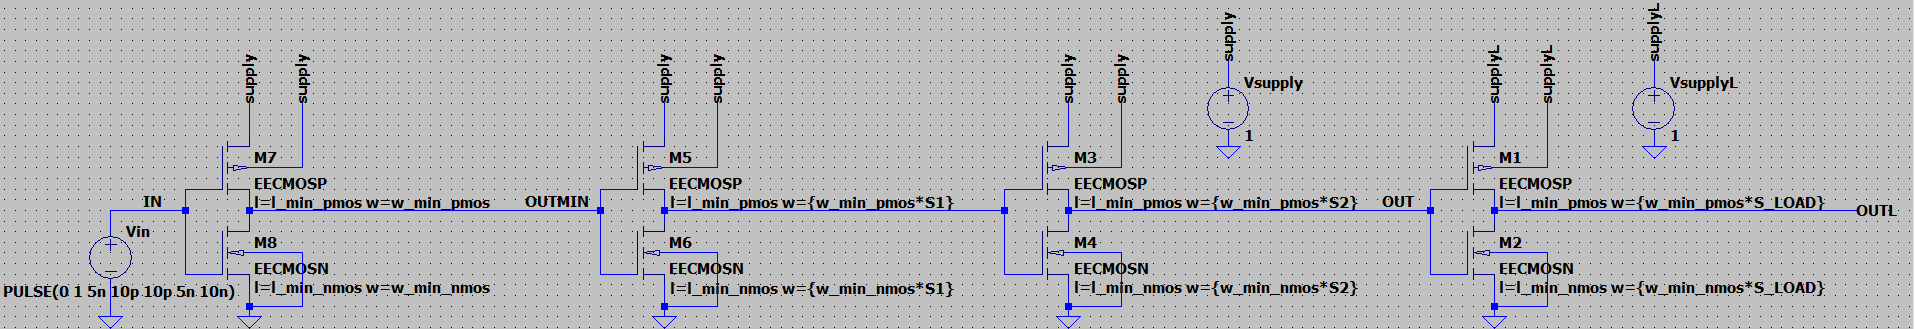

Fri Nov 24 23:20:44 2023 info: RunTask #1:: Starting simulation 1
Fri Nov 24 23:20:48 2023 info: RunTask #1:Simulation Successful. Time elapsed: 04.0360 secs

Fri Nov 24 23:20:48 2023 info: RunTask #1:Simulation Finished. No Callback function given

Raw file: data\buffer\optimized\buffer_optimized_1.raw, Log file: data\buffer\optimized\buffer_optimized_1.log
File updated successfully: ../../images/buffer_optimized_simulation.png


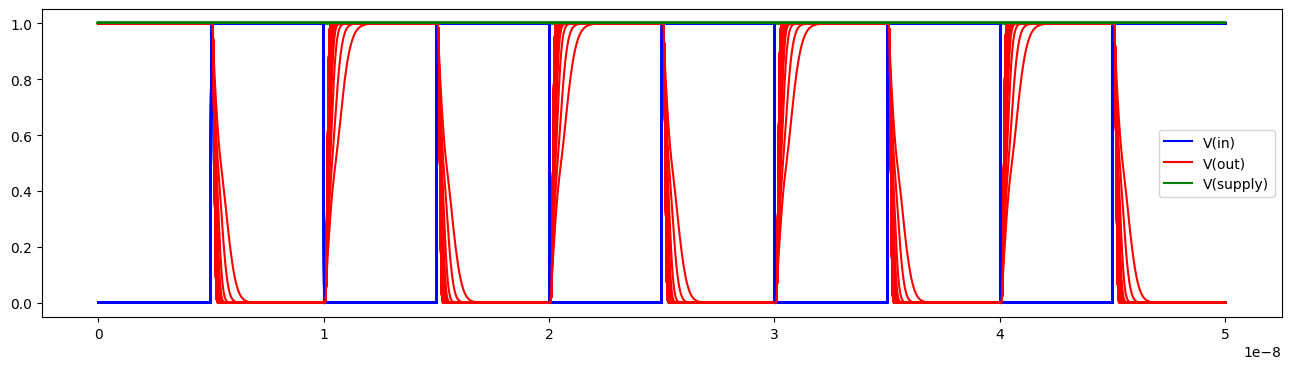

In [24]:
buffer_optimized_netlist = load_asc(
                                    asc_file_path=os.path.join(ltspice, "buffer/optimized/buffer_optimized.asc"), 
                                    schematic_image_path=os.path.join(images, "buffer_optimized.png")
                                    )
n_runs_optimized = ((d_max - d_min)/step_opt) + 1

tmp_s1_from_matlab = [(str(var1)+"," if var1!=s1_from_matlab[len(s1_from_matlab)-1] else str(var1)) for var1 in s1_from_matlab]
s1_table_optimized_from_matlab = ""
for item in tmp_s1_from_matlab:
    s1_table_optimized_from_matlab = s1_table_optimized_from_matlab + item
tmp_s2_from_matlab = [(str(var2)+"," if var2!=s2_from_matlab[len(s2_from_matlab)-1] else str(var2)) for var2 in s2_from_matlab]
s2_table_optimized_from_matlab = ""
for item in tmp_s2_from_matlab:
    s2_table_optimized_from_matlab = s2_table_optimized_from_matlab + item

S1_optimized = f' table(index,{s1_table_optimized_from_matlab})'
S2_optimized = f' table(index,{s2_table_optimized_from_matlab})'

buffer_optimized_netlist.set_parameter('l_min_pmos', l_min_pmos)
buffer_optimized_netlist.set_parameter('w_min_pmos', w_min_pmos)
buffer_optimized_netlist.set_parameter('l_min_nmos', l_min_nmos)
buffer_optimized_netlist.set_parameter('w_min_nmos', w_min_nmos)
buffer_optimized_netlist.set_parameter('S1', S1_optimized)
buffer_optimized_netlist.set_parameter('S2', S2_optimized)
buffer_optimized_netlist.set_parameter('S_LOAD', S_LOAD)
buffer_optimized_netlist.add_instructions(
                                rit_models,
                                tran,
                                f".step param index 1 {n_runs_optimized} 1",
                                energy_connected(13,22),
                                rise_delay_connected(),
                                fall_delay_connected()
                        )
buffer_optimized_runner = SimRunner(output_folder=f"{buffer_data}/optimized/")
buffer_optimized_runner.run(buffer_optimized_netlist)

buffer_optimized_raw = ""
buffer_optimized_log = ""
for buffer_optimized_raw, buffer_optimized_log in buffer_optimized_runner:
    print("Raw file: %s, Log file: %s" % (buffer_optimized_raw, buffer_optimized_log))
    

v_in_buffer_optimized = buffer_optimized_ltr.get_trace("V(in)")
v_out_buffer_optimized = buffer_optimized_ltr.get_trace("V(out)")
v_supply_buffer_optimized = buffer_optimized_ltr.get_trace("V(supply)")
time = buffer_optimized_ltr.get_trace('time')
steps = buffer_optimized_ltr.get_steps()

plt.figure(figsize=(16, 4))
for step in range(len(steps)):
    plt.plot(time.get_wave(step), v_in_buffer_optimized.get_wave(step), label=steps[step], color='blue')
    plt.plot(time.get_wave(step), v_out_buffer_optimized.get_wave(step), label=steps[step], color='red')
    plt.plot(time.get_wave(step), v_supply_buffer_optimized.get_wave(step), label=steps[step], color='green')
plt.legend(["V(in)", "V(out)", "V(supply)"])
buffer_optimized_simulation_path_image = os.path.join(images, "buffer_optimized_simulation.png")
check_output_image(buffer_optimized_simulation_path_image)
plt.savefig(buffer_optimized_simulation_path_image)
plt.show()

In [25]:
buffer_optimized_log_file_path = f"./{buffer_optimized_log}"

with open(buffer_optimized_log_file_path, "r") as file:
    content = file.read()

energy_connected_buffer_optimized_data = re.search(energy_connected_pattern, content, re.DOTALL).group(1)
rise_delay_connected_buffer_optimized_data = re.search(rise_delay_connected_pattern, content, re.DOTALL).group(1)
fall_delay_connected_buffer_optimized_data = re.search(fall_delay_connected_pattern, content, re.DOTALL).group(1)

energy_connected_buffer_optimized_lines = energy_connected_buffer_optimized_data.strip().split('\n')[1:]
rise_delay_connected_buffer_optimized_lines = rise_delay_connected_buffer_optimized_data.strip().split('\n')[1:]
fall_delay_connected_buffer_optimized_lines = fall_delay_connected_buffer_optimized_data.strip().split('\n')[1:]

energy_connected_buffer_optimized = [float(line.split('\t')[1]) for line in energy_connected_buffer_optimized_lines]
energy_connected_buffer_optimized = [abs(energy) for energy in energy_connected_buffer_optimized]
rise_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in rise_delay_connected_buffer_optimized_lines]
fall_delay_connected_buffer_optimized = [float(line.split('\t')[1]) for line in fall_delay_connected_buffer_optimized_lines]
delay_connected_buffer_optimized = [(rise_delay+fall_delay)/2 for rise_delay,fall_delay in zip(rise_delay_connected_buffer_optimized,fall_delay_connected_buffer_optimized)]

File updated successfully: ../../images/comparative_analysis_matlab.png


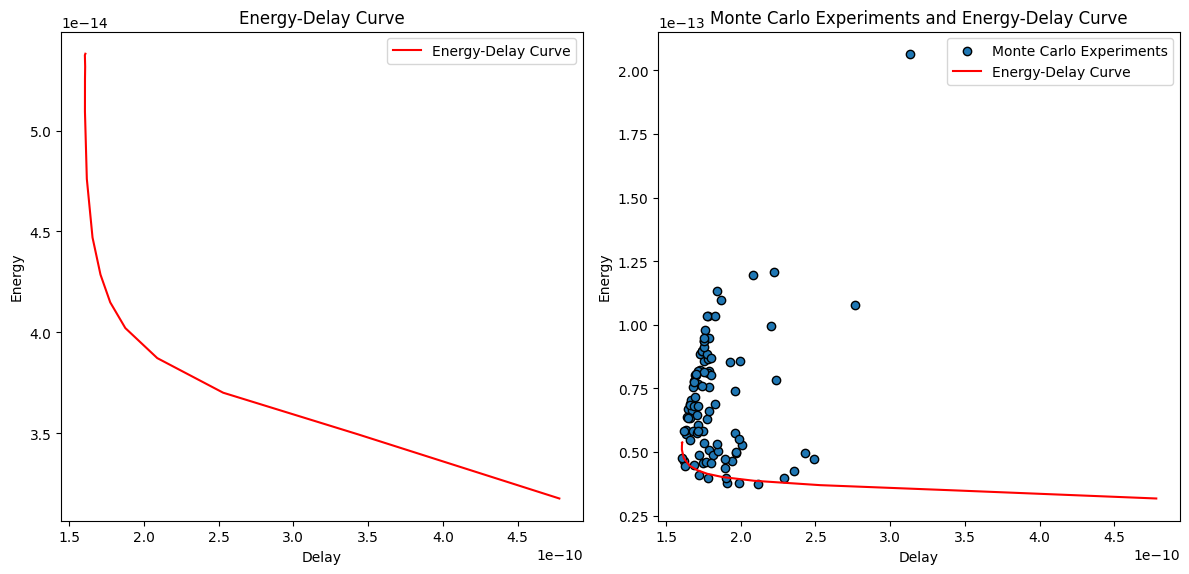

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[0].set_xlabel('Delay')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy-Delay Curve')
axs[0].legend(["Energy-Delay Curve"])

axs[1].scatter(delay_connected_buffer, energy_connected_buffer, edgecolors='black')
axs[1].plot(delay_connected_buffer_optimized, energy_connected_buffer_optimized, color='red')
axs[1].set_xlabel('Delay')
axs[1].set_ylabel('Energy')
axs[1].set_title('Monte Carlo Experiments and Energy-Delay Curve')
axs[1].legend(["Monte Carlo Experiments", "Energy-Delay Curve"])

plt.tight_layout()

comparative_analysis_path_image = os.path.join(images, "comparative_analysis_matlab.png")
check_output_image(comparative_analysis_path_image)
plt.savefig(comparative_analysis_path_image)
plt.show()

delay_connected_buffer_optimized_matlab = delay_connected_buffer_optimized
energy_connected_buffer_optimized_matlab = energy_connected_buffer_optimized

<blockquote>It can be seen that the Pareto optimal curve obtained via MATLAB's optimal dimensioning factors better approximates the hypothetical empirical curve than the one generated via the scipy.minimise optimisation algorithm.</blockquote><hr>

In [27]:
print("{:<10} {:<25} {:<25} {:<25} {:<25}".format("delay", "delay_from_python", "delay_from_matlab", "energy_from_python", "energy_from_matlab"))
for delay, delay_python, energy_python, delay_matlab, energy_matlab in zip(delay_values, delay_connected_buffer_optimized_python, energy_connected_buffer_optimized_python, delay_connected_buffer_optimized_matlab, energy_connected_buffer_optimized_matlab):
    print("{:<10} {:<25} {:<25} {:<25} {:<25}".format(delay, str(delay_python), str(delay_matlab), str(energy_python), str(energy_matlab)))

delay      delay_from_python         delay_from_matlab         energy_from_python        energy_from_matlab       
510        4.77963e-10               4.779645e-10              3.17579e-14               3.1771e-14               
500        3.3651049999999996e-10    3.431345e-10              3.3905e-14                3.49524e-14              
490        2.549165e-10              2.530845e-10              3.73859e-14               3.70117e-14              
480        2.200875e-10              2.090155e-10              4.14109e-14               3.87254e-14              
470        1.9876399999999998e-10    1.876525e-10              4.27347e-14               4.02132e-14              
460        1.895465e-10              1.77552e-10               4.37086e-14               4.14874e-14              
450        1.83061e-10               1.7103e-10                4.47214e-14               4.28624e-14              
440        1.755045e-10              1.657045e-10              4.6353e-14       

In [28]:
delay_error = []
energy_error = []
print("{:<10} {:<25} {:<25}".format("delay", "delay_error", "energy_error"))
for delay, delay_python, energy_python, delay_matlab, energy_matlab in zip(delay_values, delay_connected_buffer_optimized_python, energy_connected_buffer_optimized_python, delay_connected_buffer_optimized_matlab, energy_connected_buffer_optimized_matlab):
    delay_error_current = abs(delay_python - delay_matlab)
    energy_error_current = abs(energy_python - energy_matlab)
    delay_error.append(delay_error_current)
    energy_error.append(energy_error_current)
    print("{:<10} {:<25} {:<25}".format(delay, str(delay_error_current), str(energy_error_current)))

delay      delay_error               energy_error             
510        1.499999999961169e-15     1.3100000000001731e-17   
500        6.624000000000059e-12     1.0474000000000004e-15   
490        1.8319999999999995e-12    3.741999999999973e-16    
480        1.1071999999999985e-11    2.6855000000000015e-15   
470        1.1111499999999988e-11    2.5214999999999997e-15   
460        1.1994500000000015e-11    2.2211999999999944e-15   
450        1.2030999999999992e-11    1.8590000000000012e-15   
440        9.800000000000008e-12     1.6531000000000016e-15   
430        8.481000000000014e-12     5.86400000000005e-16     
420        6.676499999999992e-12     8.770000000000022e-16    
410        4.7754999999999956e-12    3.111000000000046e-16    
400        3.5315000000000255e-12    1.7942000000000054e-15   
390        3.363500000000006e-12     3.7986e-15               
380        3.284999999999979e-12     6.148500000000009e-15    
370        3.284999999999979e-12     6.148500000000009e

File updated successfully: ../../images/energy_delay_error.png


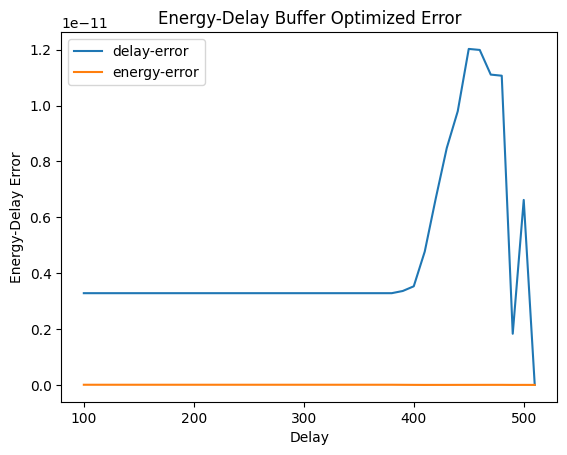

In [29]:
plt.plot(delay_values, delay_error, label='delay-error')
plt.plot(delay_values, energy_error, label='energy-error')
plt.legend()
plt.xlabel('Delay'); plt.ylabel('Energy-Delay Error'); plt.title('Energy-Delay Buffer Optimized Error')
energy_delay_error_path_image = os.path.join(images, "energy_delay_error.png")
check_output_image(energy_delay_error_path_image)
plt.savefig(energy_delay_error_path_image)
plt.show()